# Part 1. Install Packages

In [9]:
## install required packages
!pip install swig
!pip install wrds
!pip install pyportfolioopt
## install finrl library
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/AI4Finance-Foundation/FinRL.git to /tmp/pip-req-build-wnrupg3j
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/FinRL.git /tmp/pip-req-build-wnrupg3j
  Resolved https://github.com/AI4Finance-Foundation/FinRL.git to commit ab7140009ad1bea1867f241df14daffd0baacb2e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/quantopian/pyfolio.git to /tmp/pip-install-dv2d93jd/pyfolio_37860a2cf0a9436dbd1c8f226c675da0
  Runnin

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3.common.logger import configure
from finrl.meta.data_processor import DataProcessor
from stable_baselines3 import A2C, DDPG, PPO, SAC, TD3

%matplotlib inline
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint

In [11]:
from finrl import config
from finrl import config_tickers
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)
check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

# Part 2. Backtesting

In [66]:
processed_full = pd.read_csv('full_data.csv')

TRADE_START_DATE = '2020-07-01'
TRADE_END_DATE = '2021-10-29'

trade = data_split(processed_full, TRADE_START_DATE,TRADE_END_DATE)

In [67]:
if_using_a2c = True
if_using_ddpg = False
if_using_ppo = False
if_using_td3 = False
if_using_sac = False

### Set turbulence threshold
Set the turbulence threshold to be greater than the maximum of insample turbulence data. If current turbulence index is greater than the threshold, then we assume that the current market is volatile

In [75]:
data_risk_indicator = processed_full[(processed_full.date<TRAIN_END_DATE) & (processed_full.date>=TRAIN_START_DATE)]
insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])

In [76]:
insample_risk_indicator.vix.describe()

count    1654.000000
mean       16.473337
std         7.673456
min         9.140000
25%        12.420000
50%        14.210000
75%        17.565000
max        82.690002
Name: vix, dtype: float64

In [77]:
insample_risk_indicator.vix.quantile(0.996)

64.56692082214343

In [78]:
insample_risk_indicator.turbulence.describe()

count    1654.000000
mean       40.860010
std        51.973783
min         2.490563
25%        17.299272
50%        26.440291
75%        44.575789
max       652.506131
Name: turbulence, dtype: float64

In [79]:
insample_risk_indicator.turbulence.quantile(0.996)

426.4778093088604

### Load trained agents

In [80]:
trained_a2c = A2C.load("agent_a2c") if if_using_a2c else None
trained_ddpg = DDPG.load("agent_a2c") if if_using_ddpg else None
trained_ppo = PPO.load("agent_a2c") if if_using_ppo else None
trained_td3 = TD3.load("agent_a2c") if if_using_td3 else None
trained_sac = SAC.load("agent_a2c") if if_using_sac else None

### Trading (Out-of-sample Performance)

We update periodically in order to take full advantage of the data, e.g., retrain quarterly, monthly or weekly. We also tune the parameters along the way, in this notebook we use the in-sample data from 2009-01 to 2020-07 to tune the parameters once, so there is some alpha decay here as the length of trade date extends. 

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [81]:
stock_dimension = len(trade.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 29, State Space: 291


In [82]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}

In [83]:
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

In [84]:
df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
    model=trained_a2c, 
    environment = e_trade_gym) if if_using_a2c else (None, None)

hit end!


In [ ]:
df_account_value_ddpg, df_actions_ddpg = DRLAgent.DRL_prediction(
    model=trained_ddpg, 
    environment = e_trade_gym) if if_using_ddpg else (None, None)

In [ ]:
df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(
    model=trained_ppo, 
    environment = e_trade_gym) if if_using_ppo else (None, None)

In [ ]:
df_account_value_td3, df_actions_td3 = DRLAgent.DRL_prediction(
    model=trained_td3, 
    environment = e_trade_gym) if if_using_td3 else (None, None)

In [ ]:
df_account_value_sac, df_actions_sac = DRLAgent.DRL_prediction(
    model=trained_sac, 
    environment = e_trade_gym) if if_using_sac else (None, None)

# Part 3: Mean Variance Optimization

In [85]:
mvo_df = processed_full.sort_values(['date','tic'],ignore_index=True)[['date','tic','close']]

In [86]:
mvo_df.head()

,date,tic,close
0,2009-01-02,AAPL,2.762747
1,2009-01-02,AMGN,44.219173
2,2009-01-02,AXP,15.365306
3,2009-01-02,BA,33.941101
4,2009-01-02,CAT,31.579334


In [87]:
fst = mvo_df
fst = fst.iloc[0*29:0*29+29, :]
tic = fst['tic'].tolist()

mvo = pd.DataFrame()

for k in range(len(tic)):
  mvo[tic[k]] = 0

for i in range(mvo_df.shape[0]//29):
  n = mvo_df
  n = n.iloc[i*29:i*29+29, :]
  date = n['date'][i*29]
  mvo.loc[date] = n['close'].tolist()

In [88]:
mvo.shape[0]

3228

### Helper functions for mean returns and variance-covariance matrix

Code from this section refer to Dr G A Vijayalakshmi Pai

https://www.kaggle.com/code/vijipai/lesson-5-mean-variance-optimization-of-portfolios/notebook

In [89]:
from scipy import optimize 
from scipy.optimize import linprog

#function obtains maximal return portfolio using linear programming

def MaximizeReturns(MeanReturns, PortfolioSize):
    
  #dependencies
  c = (np.multiply(-1, MeanReturns))
  A = np.ones([PortfolioSize,1]).T
  b=[1]
  res = linprog(c, A_ub = A, b_ub = b, bounds = (0,1), method = 'simplex') 
    
  return res

def MinimizeRisk(CovarReturns, PortfolioSize):
    
  def f(x, CovarReturns):
    func = np.matmul(np.matmul(x, CovarReturns), x.T) 
    return func

  def constraintEq(x):
    A=np.ones(x.shape)
    b=1
    constraintVal = np.matmul(A,x.T)-b 
    return constraintVal
    
  xinit=np.repeat(0.1, PortfolioSize)
  cons = ({'type': 'eq', 'fun':constraintEq})
  lb = 0
  ub = 1
  bnds = tuple([(lb,ub) for x in xinit])

  opt = optimize.minimize (f, x0 = xinit, args = (CovarReturns),  bounds = bnds, \
                             constraints = cons, tol = 10**-3)
    
  return opt

def MinimizeRiskConstr(MeanReturns, CovarReturns, PortfolioSize, R):
    
  def  f(x,CovarReturns):
         
    func = np.matmul(np.matmul(x,CovarReturns ), x.T)
    return func

  def constraintEq(x):
    AEq=np.ones(x.shape)
    bEq=1
    EqconstraintVal = np.matmul(AEq,x.T)-bEq 
    return EqconstraintVal
    
  def constraintIneq(x, MeanReturns, R):
    AIneq = np.array(MeanReturns)
    bIneq = R
    IneqconstraintVal = np.matmul(AIneq,x.T) - bIneq
    return IneqconstraintVal
    

  xinit=np.repeat(0.1, PortfolioSize)
  cons = ({'type': 'eq', 'fun':constraintEq},
          {'type':'ineq', 'fun':constraintIneq, 'args':(MeanReturns,R) })
  lb = 0
  ub = 1
  bnds = tuple([(lb,ub) for x in xinit])

  opt = optimize.minimize (f, args = (CovarReturns), method ='trust-constr',  \
                x0 = xinit,   bounds = bnds, constraints = cons, tol = 10**-3)
    
  return opt

In [90]:
def StockReturnsComputing(StockPrice, Rows, Columns): 
  import numpy as np 
  StockReturn = np.zeros([Rows-1, Columns]) 
  for j in range(Columns):        # j: Assets 
    for i in range(Rows-1):     # i: Daily Prices 
      StockReturn[i,j]=((StockPrice[i+1, j]-StockPrice[i,j])/StockPrice[i,j])* 100 
      
  return StockReturn

### Calculate the weights for mean-variance

In [91]:
trade_days = trade.shape[0]//29

StockData = mvo.head(mvo.shape[0]-trade_days)
TradeData = mvo.tail(trade_days)

TradeData.to_numpy()

array([[ 89.631, 236.683,  91.078, ...,  47.767,  36.77 , 115.097],
       [ 89.631, 239.578,  91.35 , ...,  47.872,  37.76 , 114.636],
       [ 92.029, 237.732,  93.529, ...,  48.265,  38.821, 114.328],
       ...,
       [147.567, 199.597, 179.354, ...,  49.08 ,  46.593, 147.145],
       [148.242, 200.606, 178.016, ...,  49.546,  45.732, 145.861],
       [147.775, 198.588, 175.143, ...,  49.126,  44.605, 144.664]])

In [92]:
#compute asset returns
arStockPrices = np.asarray(StockData)
[Rows, Cols]=arStockPrices.shape
arReturns = StockReturnsComputing(arStockPrices, Rows, Cols)

#compute mean returns and variance covariance matrix of returns
meanReturns = np.mean(arReturns, axis = 0)
covReturns = np.cov(arReturns, rowvar=False)
 
#set precision for printing results
np.set_printoptions(precision=3, suppress = True)

#display mean returns and variance-covariance matrix of returns
print('Mean returns of assets in k-portfolio 1\n', meanReturns)
print('Variance-Covariance matrix of returns\n', covReturns)

Mean returns of assets in k-portfolio 1
 [0.136 0.068 0.086 0.083 0.066 0.134 0.06  0.035 0.072 0.056 0.103 0.073
 0.033 0.076 0.047 0.073 0.042 0.056 0.054 0.056 0.103 0.089 0.041 0.053
 0.104 0.11  0.044 0.042 0.042]
Variance-Covariance matrix of returns
 [[3.156 1.066 1.768 1.669 1.722 1.814 1.569 1.302 1.302 1.811 1.303 1.432
  1.218 1.674 0.74  1.839 0.719 0.884 1.241 0.823 1.561 1.324 0.752 1.027
  1.298 1.466 0.657 1.078 0.631]
 [1.066 2.571 1.306 1.123 1.193 1.319 1.116 1.053 1.045 1.269 1.068 1.089
  0.899 1.218 0.926 1.391 0.682 0.727 1.025 1.156 1.166 0.984 0.798 0.956
  1.259 1.111 0.688 1.091 0.682]
 [1.768 1.306 4.847 2.73  2.6   2.128 1.944 2.141 2.17  3.142 1.932 2.283
  1.56  2.012 0.993 3.707 1.094 1.319 1.845 1.236 1.899 1.894 1.041 1.921
  1.823 2.314 0.986 1.421 0.707]
 [1.669 1.123 2.73  4.892 2.363 1.979 1.7   2.115 1.959 2.387 1.773 2.319
  1.571 1.797 0.968 2.597 1.144 1.298 1.643 1.071 1.615 1.775 0.91  1.666
  1.707 1.784 0.82  1.345 0.647]
 [1.722 1.193 2.6 

In [93]:
from pypfopt.efficient_frontier import EfficientFrontier

ef_mean = EfficientFrontier(meanReturns, covReturns, weight_bounds=(0, 0.5))
raw_weights_mean = ef_mean.max_sharpe()
cleaned_weights_mean = ef_mean.clean_weights()
mvo_weights = np.array([1000000 * cleaned_weights_mean[i] for i in range(29)])

In [94]:
mvo_weights

array([424250.,      0.,      0.,      0.,      0., 108650.,      0.,
            0.,      0.,      0., 181450.,      0.,      0.,      0.,
            0.,      0.,      0.,      0.,      0.,      0.,  16960.,
            0.,      0.,      0., 133540., 135150.,      0.,      0.,
            0.])

In [95]:
LastPrice = np.array([1/p for p in StockData.tail(1).to_numpy()[0]])
Initial_Portfolio = np.multiply(mvo_weights, LastPrice)
Initial_Portfolio

array([4724.332,    0.   ,    0.   ,    0.   ,    0.   ,  579.993,
          0.   ,    0.   ,    0.   ,    0.   ,  766.21 ,    0.   ,
          0.   ,    0.   ,    0.   ,    0.   ,    0.   ,    0.   ,
          0.   ,    0.   ,   85.251,    0.   ,    0.   ,    0.   ,
        468.596,  711.408,    0.   ,    0.   ,    0.   ])

In [96]:
Portfolio_Assets = TradeData @ Initial_Portfolio
MVO_result = pd.DataFrame(Portfolio_Assets, columns=["Mean Var"])
MVO_result

,Mean Var
2020-07-01,1.001918e+06
2020-07-02,1.004235e+06
2020-07-06,1.023225e+06
2020-07-07,1.014021e+06
2020-07-08,1.029461e+06
...,...
2021-10-21,1.533023e+06
2021-10-22,1.535668e+06
2021-10-25,1.542078e+06
2021-10-26,1.545514e+06


### Optimal weights of the efficient set portfolios: 

In [97]:
result1 = MaximizeReturns(meanReturns, 29)
maxReturnWeights = result1.x
maxExpPortfolioReturn = np.matmul(meanReturns.T, maxReturnWeights)
print("Maximal Expected Portfolio Return:   %7.4f" % maxExpPortfolioReturn )

Maximal Expected Portfolio Return:    0.1362


In [98]:
result2 = MinimizeRisk(covReturns, 29)
minRiskWeights = result2.x
minRiskExpPortfolioReturn = np.matmul(meanReturns.T, minRiskWeights)
print("Expected Return of Minimum Risk Portfolio:  %7.4f" % minRiskExpPortfolioReturn)

Expected Return of Minimum Risk Portfolio:   0.0458


In [99]:
increment = 0.001
low = minRiskExpPortfolioReturn
high = maxExpPortfolioReturn

#initialize optimal weight set and risk-return point set
xOptimal =[]
minRiskPoint = []
expPortfolioReturnPoint =[]

#repeated execution of function MinimizeRiskConstr to determine the efficient set 
while (low < high):
    
    result3 = MinimizeRiskConstr(meanReturns, covReturns, 29, low)
    xOptimal.append(result3.x)
    expPortfolioReturnPoint.append(low)
    low = low+increment
    
#gather optimal weight set    
xOptimalArray = np.array(xOptimal)

#obtain annualized risk for the efficient set portfolios 
#for trading days = 251
minRiskPoint = np.diagonal(np.matmul((np.matmul(xOptimalArray,covReturns)),\
                                     np.transpose(xOptimalArray)))
riskPoint =   np.sqrt(minRiskPoint*251) 

#obtain expected portfolio annualized return for the 
#efficient set portfolios, for trading days = 251
retPoint = 251*np.array(expPortfolioReturnPoint) 

#display efficient set portfolio parameters
# print("Size of the  efficient set:", xOptimalArray.shape )
# print("Optimal weights of the efficient set portfolios: \n", xOptimalArray[-3:])
# print("Annualized Risk and Return of the efficient set portfolios: \n", \
#                                                 np.c_[riskPoint, retPoint])

/usr/local/lib/python3.8/dist-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


<a id='6'></a>
# Part 8: Backtesting Results
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

In [100]:
df_result_a2c = df_account_value_a2c.set_index(df_account_value_a2c.columns[0]) if if_using_a2c else None
df_result_ddpg = df_account_value_ddpg.set_index(df_account_value_ddpg.columns[0]) if if_using_ddpg else None
df_result_ppo = df_account_value_ppo.set_index(df_account_value_ppo.columns[0]) if if_using_ppo else None
df_result_td3 = df_account_value_td3.set_index(df_account_value_td3.columns[0]) if if_using_td3 else None
df_result_sac = df_account_value_sac.set_index(df_account_value_sac.columns[0]) if if_using_sac else None

result = pd.DataFrame()
if if_using_a2c: result = pd.merge(result, df_result_a2c, how='outer', left_index=True, right_index=True)
if if_using_ddpg: result = pd.merge(result, df_result_ddpg, how='outer', left_index=True, right_index=True)
if if_using_ppo: result = pd.merge(result, df_result_ppo, how='outer', left_index=True, right_index=True)
if if_using_td3: result = pd.merge(result, df_result_td3, how='outer', left_index=True, right_index=True)
if if_using_sac: result = pd.merge(result, df_result_sac, how='outer', left_index=True, right_index=True)
result = pd.merge(result, MVO_result, how='outer', left_index=True, right_index=True)
# result = pd.merge(result, dji, how='outer', left_index=True, right_index=True).fillna(method='bfill')

In [101]:
col_name = []
col_name.append('A2C') if if_using_a2c else None
col_name.append('DDPG') if if_using_ddpg else None
col_name.append('PPO') if if_using_ppo else None
col_name.append('TD3') if if_using_td3 else None
col_name.append('SAC') if if_using_sac else None
col_name.append('Mean Var')
# col_name.append('djia')
result.columns = col_name

In [102]:
result

,A2C,Mean Var
date,,
2020-07-01,1.000000e+06,1.001918e+06
2020-07-02,1.000735e+06,1.004235e+06
2020-07-06,1.006605e+06,1.023225e+06
2020-07-07,9.970967e+05,1.014021e+06
2020-07-08,1.001761e+06,1.029461e+06
...,...,...
2021-10-21,1.364070e+06,1.533023e+06
2021-10-22,1.374122e+06,1.535668e+06
2021-10-25,1.380883e+06,1.542078e+06


<Figure size 1080x360 with 0 Axes>

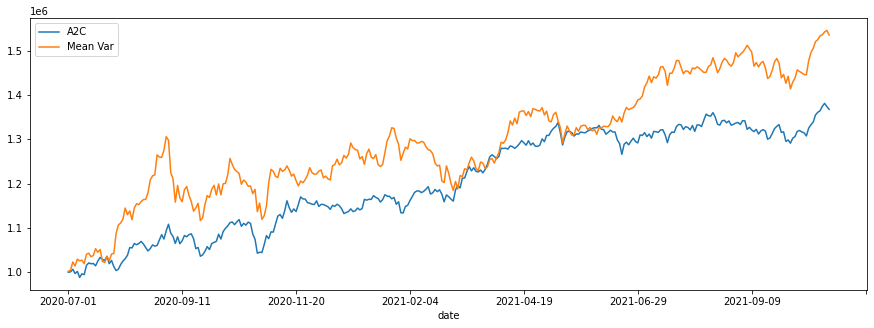

In [103]:
plt.rcParams["figure.figsize"] = (15,5)
plt.figure()
result.plot()